In [2]:
# Libraries

import vegas  
import numpy as np
import lhapdf
from matplotlib import pyplot as plt

## PDFs


This part plots the PDFs (plots are in agreement with David's notes)

LHAPDF 6.5.4 loading /Users/francescomontagno2/miniconda3/envs/lhapdf-muc/share/LHAPDF/MSHT20nnlo_as118/MSHT20nnlo_as118_0000.dat
MSHT20nnlo_as118 PDF set, member #0, version 4; LHAPDF ID = 27400


/var/folders/j3/35chk69569z8llqry75sy88m0000gp/T/ipykernel_22360/4026014426.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,1.2)


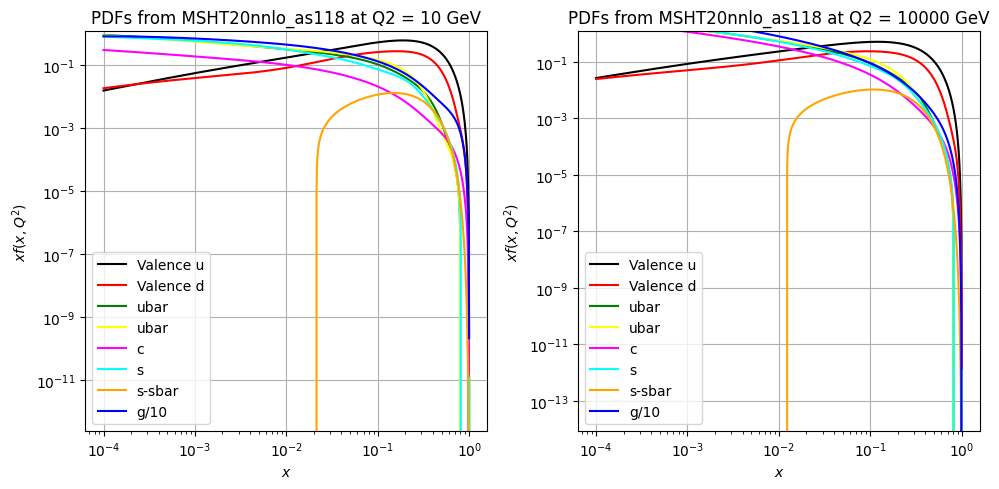

In [3]:
#  PDFs - Checking they give the same plot as David's notes

pdf_set_name = "MSHT20nnlo_as118"
pdf = lhapdf.mkPDF(pdf_set_name, 0)

xs = np.logspace(-4, 0, 1000) 

Q2_values = [10, 10000]  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, Q2 in enumerate(Q2_values):
    ax = axs[ i % 2]  
    
    
    u       = np.array([pdf.xfxQ2(2,x,Q2) for x in xs])
    ubar    = np.array([pdf.xfxQ2(-2,x,Q2) for x in xs])
    d       = np.array([pdf.xfxQ2(1,x,Q2) for x in xs])
    dbar    = np.array([pdf.xfxQ2(-1,x,Q2) for x in xs])
    c       = np.array([pdf.xfxQ2(4,x,Q2) for x in xs])
    s       = np.array([pdf.xfxQ2(3,x,Q2) for x in xs])
    sbar    = np.array([pdf.xfxQ2(-3,x,Q2) for x in xs])
    g       = np.array([pdf.xfxQ2(21,x,Q2) for x in xs])
    
    
    ax.plot(xs,u-ubar,label='Valence u',color='black' )
    ax.plot(xs,d-dbar,label='Valence d',color='red' )
    ax.plot(xs,ubar,label='ubar',color='green' )
    ax.plot(xs,dbar,label='ubar',color='yellow' )
    ax.plot(xs,c,label='c',color='magenta' )
    ax.plot(xs,s,label='s',color='#00FFFF' )
    ax.plot(xs,s-sbar,label='s-sbar',color='orange' )
    ax.plot(xs,g/10,label='g/10' ,color='blue')
    
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$x f(x, Q^2)$")
    ax.set_title(f"PDFs from {pdf_set_name} at Q2 = {Q2} GeV")
    ax.legend()
    ax.set_ylim(0,1.2)
    ax.grid(True)

plt.tight_layout()

plt.show()


In [3]:
# Physical Consts

G_F     = 1.1663787e-5  # Fermi coupling constant (GeV^-2)
m_mu    = 0.1057        # muon mass
m_p     = 0.938         # proton mass
Eboost  = 5000          # muon energy 

η       =  np.log(Eboost/m_mu * (1+ np.sqrt(1- (m_mu/Eboost)**2)))            # muon rapidity
print("muon rapidity ",η)

muon rapidity  11.457490757970403


## Neutrino Distribution

We started from $\frac{d\Gamma}{d^3p_{\nu,CM}}$ (see Okun - Leptons and Quarks 3.2 - You can find a PDF copy in my folder "References"). 

Then we did a change of variables $ dp_z\to dp_+$ making easier integrating over the transverse momentum. 

We boosted the muon in the lab frame and, identifying $2E_{\nu,LAB}\sim p_{+,\nu,LAB}$, we obtained  
$\frac{d\Gamma}{dE} = 2  e^{-\eta}\frac{G_{F}^2 m_\mu}{576\pi^3}(5m_\mu^3-9m_\mu (2  e^{-\eta} E)^2+4(2  e^{-\eta} E)^3) $, where $E$ is the neutrino energy in the LAB frame. 


Finally, we verified that the integral $\int_0^{E_{\mu}}\frac{d\Gamma}{dE}dE$ numerically gives the same results as the analytical expression $\Gamma =\frac{G_F^2 m_\mu^5}{192\pi^3}$

In [4]:
def dGamma_dE(E_neutrino):    
    
    E_nu = E_neutrino
    
    #LAB
    qplus = np.exp(-η) * 2 * E_nu # q+ = exp(-eta) q'+ , q'+\sim 2E' (E' = en in the lab frame)
    dGamma =  2*np.exp(- η) * G_F**2 *m_mu /(576*np.pi**3) * (5 * m_mu**3 -9 * m_mu * qplus**2 + 4 * qplus**3)
    
    #COM
    #dGamma = G_F**2 /(12* np.pi ** 3 )* (3*m_mu**2-4*m_mu * E_nu) *E_nu**2
    return dGamma

In [5]:
Width = vegas.Integrator([0,Eboost]) # LAB - Specify the integration range
#Width = vegas.Integrator([0,m_mu/2]) # COM 

result = Width(dGamma_dE, nitn=20, neval=100000)

'''print("Integral: ", result.mean)
print("Error: ", result.sdev)'''

print("Integrated Width [GeV^ -1]: ", result)
print("Okun Result: ",G_F**2 * m_mu**5/ (192 * np.pi**3))


Integrated Width [GeV^ -1]:  3.01511058(18)e-19
Okun Result:  3.0151106170692746e-19


## Extracting the events from the distribution

Once we have integrated our distribution, we can extract events taking random points with the relative weight. 

Then, the weight to be associated to the variable $ x $  is given by wgt $\times f(x)$ where wgt is the weight given by Vegas and $f(x)$ is the sampling distribution. 

In our case, it means we can obtain the Neutrino energy distribution taking random $\bar E_{\nu,i}$ points and  associating to each of them a weight wgt $\times \frac{d\Gamma}{dE}(\bar E_{\nu,i})$

In [6]:
Neutrino_Energy = np.array([])
Neutrino_weight = np.array([])

for x, wgt in Width.random():
    Neutrino_Energy = np.append(Neutrino_Energy, x[0])
    Neutrino_weight = np.append(Neutrino_weight,wgt)

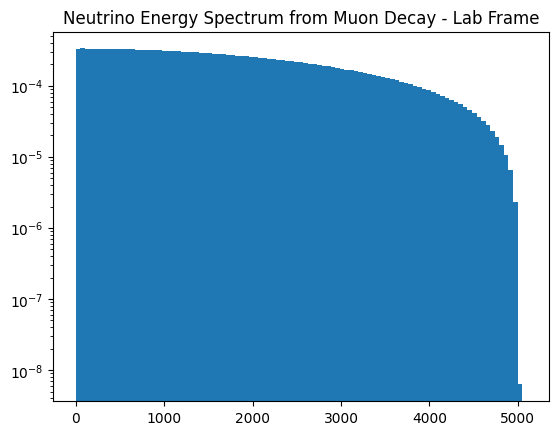

In [7]:
plt.hist(Neutrino_Energy,bins=np.linspace(0,5100,100),density=True,weights=Neutrino_weight*dGamma_dE(Neutrino_Energy))
plt.yscale('log')
plt.title('Neutrino Energy Spectrum from Muon Decay - Lab Frame')
plt.show()

## Cross Section

Here we calculate the Cross section $\sigma(E_\nu) = \int dx dy \frac{d^2\sigma}{dxdy}$, where 

$\frac{d^2\sigma}{dxdy}$  are listed in Okun - 17.7 (please notice that $ u(x)$ stands for our $ x \times f_u(x)$)

In [24]:
# Reference : chapter 17 Okun, their notation is u(x) = x f(x)

Qmin = 3  # minimal value of the factorisation scale Q


def dsigma_dxdy(variables):
    x, y = variables
    s       = m_p**2 + 2 * m_p * E_nu
    Q2      = x * y * s
    Q = np.sqrt(Q2)
    fd      = pdf.xfxQ2(1, x, Q2) 
    fubar   = pdf.xfxQ2(-2,x,Q2) 
    fs      = pdf.xfxQ2(3,x,Q2)

    dsigma  = G_F**2 * s / np.pi * ( fd + fs + fubar * (1-y)**2)*np.heaviside(Q-Qmin,0)  
    return dsigma

In [25]:
#Fix Neutrino energy
E_nu = 4000 # GeV


sigma = vegas.Integrator([[1e-4, 1], [  1e-4, 1]])

result = sigma(dsigma_dxdy, nitn=20, neval=30000)

print("Neutrino Energy (lab frame) ",E_nu,"GeV")
print("Cross Section [GeV ^ -2]",result)
print("Cross Section [cm  ^  2]",result * (1.98e-14)**2)
print("Cross Section [pb      ]",result * 0.389379 * 1e9)




Neutrino Energy (lab frame)  4000 GeV
Cross Section [GeV ^ -2] 4.72310(34)e-08
Cross Section [cm  ^  2] 1.85164(13)e-35
Cross Section [pb      ] 18.3908(13)


### Here we do the same calculation, convoluting the cross section with the neutrino energy distribution obtaining the total cross section 

$\sigma = \int dE dx dy \frac{d\Gamma}{dE}\frac{d^2\sigma}{dxdy}$

In [10]:
# Reference : chapter 17 Okun, their notation is u(x) = x f(x)
def dGamma_dE_times_dsigma_dxdy(variables):
    x, y, E_nu = variables
    
    qplus = np.exp(-η) * 2 * E_nu # q+ = exp(-eta) q'+ , q'+\sim 2E' (E' = en in the lab frame)
    dGamma  = 2 * np.exp(- η) * G_F**2 *m_mu /(576*np.pi**3) * (5 * m_mu**3 -9 * m_mu * qplus**2 + 4 * qplus**3)

    s       = m_p**2 + 2 * m_p * E_nu
    Q2      = x * y * s
    fd      = pdf.xfxQ2(1, x, Q2) 
    fubar   = pdf.xfxQ2(-2,x,Q2) 
    fs      = pdf.xfxQ2(2,x,Q2)

    dsigma  = G_F**2 * s / np.pi * ( fd + fs + fubar * (1-y)**2)  
    return dsigma*dGamma

In [11]:

integral = vegas.Integrator([[0, 1], [0, 1],[0,Eboost]])

result = integral(dGamma_dE_times_dsigma_dxdy, nitn=10, neval=30000)
print(result)

print("Integral: ", result.mean)
print("Error: ", result.sdev)


1.54802(25)e-26
Integral:  1.5480186729870823e-26
Error:  2.5314638942685966e-30


## Generalizing the code

In this section we want to make easy to generate processes with different flavours in initial and final state

In [12]:

V_CKM = { # CKM Matrix
    "V_ud": 0.97367, "V_cd": 0.22431, "V_td": 0.00382,
    "V_us": 0.221,   "V_cs": 0.975,   "V_ts": 0.0411,
    "V_ub": 0.0086,  "V_cb": 0.0415,  "V_tb": 1.010
}

CKM_switch = { # Choose which CKM elements to be turned on
    "V_ud": 1,
    "V_cd": 1,
    "V_td": 1,
    "V_us": 1,
    "V_cs": 1,
    "V_ts": 1,
    "V_ub": 1,
    "V_cb": 1,
    "V_tb": 1
}

PDF_switch = {
    "fd":       1,     
    "fs":       1,     
    "fubar":    1   
}

sum_Vd = 0
sum_Vs = 0
sum_Vu = 0
    





In [13]:
def dGamma_dE_times_dsigma_dxdy(variables):
    x, y = variables
    
    #qplus = np.exp(-η) * 2 * E_nu # q+ = exp(-eta) q'+ , q'+\sim 2E' (E' = en in the lab frame)
    #dGamma  = 2 * np.exp(- η) * G_F**2 *m_mu /(576*np.pi**3) * (5 * m_mu**3 -9 * m_mu * qplus**2 + 4 * qplus**3)

    s       = m_p**2 + 2 * m_p * E_nu
    Q2      = x * y * s
    fd      = pdf.xfxQ2(1, x, Q2) 
    fubar   = pdf.xfxQ2(-2,x,Q2) 
    fs      = pdf.xfxQ2(2,x,Q2)

    
    dsigma  = G_F**2 * s / np.pi * ( PDF_switch["fd"] * fd * d_contribution + PDF_switch["fs"] *fs *s_contribution +  PDF_switch["fubar"] *fubar * (1-y)**2 * u_contribution)  
    #return dsigma*dGamma
    return dsigma

### Choosing the initial and final state

In order to choose which parton is initializing the process, modify the PDF_Swtich : '0' means no contribution from that parton, '1' means contribution from that parton

In order to choose the final state quark, modify the CKM_switch : '0' means forbidding a specific transition, '1' means allowing. 

For example: if PDF_Switch has {1,0,1} it means that I will consider only processes initialized by d and ubar quarks, no strange. If CKM_switch = {0 1 0 0 1 0 0 0 0} it means that I will only consider final states given by d->c and s->c transitions. All {1....1} both in PDF and CKM switch give an inclusive process 

In [14]:
# Modify this part to choose the process
CKM_switch = { 
    "V_ud": 1,
    "V_cd": 1,
    "V_td": 0,
    "V_us": 1,
    "V_cs": 1,
    "V_ts": 0,
    "V_ub": 0,
    "V_cb": 0,
    "V_tb": 0
}

PDF_switch = {
    "fd":       1,     
    "fs":       1,     
    "fubar":    0   
}

d_contribution = CKM_switch["V_ud"] * V_CKM["V_ud"]**2 + CKM_switch["V_cd"] * V_CKM["V_cd"]**2 + CKM_switch["V_td"] * V_CKM["V_td"]**2
s_contribution = CKM_switch["V_us"] * V_CKM["V_us"]**2 + CKM_switch["V_cs"] * V_CKM["V_cs"]**2 + CKM_switch["V_ts"] * V_CKM["V_ts"]**2
u_contribution = CKM_switch["V_ud"] * V_CKM["V_ud"]**2 + CKM_switch["V_us"] * V_CKM["V_us"]**2 + CKM_switch["V_ub"] * V_CKM["V_ub"]**2
print(d_contribution,s_contribution,u_contribution)

#Fix Neutrino energy
E_nu = 1000 # GeV


sigma = vegas.Integrator([[0, 1], [0, 1]])

result = sigma(dGamma_dE_times_dsigma_dxdy, nitn=15, neval=30000)

print("Neutrino Energy (lab frame) ",E_nu,"GeV")
print("Cross Section [GeV ^ -2]",result)
print("Cross Section [cm  ^  2]",result * (1.98e-14)**2)

0.9983482450000001 0.999466 0.9968742689000001
Neutrino Energy (lab frame)  1000 GeV
Cross Section [GeV ^ -2] 2.92980(12)e-08
Cross Section [cm  ^  2] 1.148598(47)e-35


In [15]:
#Neutrino_Energy = np.array([])
X               = np.array([])
Y               = np.array([])
WGT = np.array([])

for x, wgt in sigma.random():
    X               = np.append(X, x[0])
    Y               = np.append(Y, x[1])
    #Neutrino_Energy = np.append(Neutrino_Energy, x[2])
    WGT = np.append(WGT,wgt)